In [1]:
import random

# for data, model, training
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa

import matplotlib.pyplot as plt
import seaborn as sns

import basics

# Set the seed value for experiment reproducibility.
seed = 42
random.seed(42)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
filenames = basics.get_and_shuffle_filenames("./recordings")

print(filenames[:5])

['./recordings/2_jackson_13.wav', './recordings/6_george_34.wav', './recordings/7_george_5.wav', './recordings/1_yweweler_21.wav', './recordings/2_george_42.wav']


In [3]:
X_unfiltered = [(file_path, basics.decode_audio(file_path)) for file_path in filenames]

# to remove outliers 
max_length = basics.get_max_length(X_unfiltered)
print(max_length)

5632


In [4]:
X_full = [] # padded X values 0-7
y_full = []

numbers = [0] * 8

for file_path, audio in X_unfiltered:
    x_val = audio
    y_val = basics.get_label(file_path)
    signal_length = audio.shape[0]
    
    if y_val > 7:
        continue
    if signal_length > max_length:
        numbers[y_val] += 1
        continue
        
    x_val = np.pad(
        x_val, (0, max_length - signal_length), 
        'constant', constant_values=(0, 0))

    x_spect = basics.spect(x_val, max_length)
    x_spect = x_spect.flatten()

    X_full.append(x_spect)
    y_full.append(y_val)

X_full = np.array(X_full)
y_full = np.array(y_full)

print(X_full.shape)

num_samples, sample_w = X_full.shape
print(num_samples)
print(sample_w)

print(y_full[:10])

(2312, 2816)
2312
2816
[2 6 7 1 2 6 6 4 3 2]


In [5]:
# dropped outliers
df = pd.DataFrame.from_dict({"quantities": numbers})
print(df)
print(sum(numbers))

   quantities
0          12
1           9
2           7
3           9
4           3
5           8
6          29
7          11
88


In [6]:
# normalize data
X_full = basics.normalize_arr(X_full)

# partition into 80:10:10
partitions = basics.split_full(X_full, y_full)

X_train, y_train = partitions[0]
X_val, y_val = partitions[1]
X_test, y_test = partitions[2]

print('Training set size', len(X_train))
print('Validation set size', len(X_val))
print('Test set size', len(X_test))

Training set size 1848
Validation set size 231
Test set size 233


In [7]:
# INPUTS ARE NORMALIZED

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Reshape((128, 22, 1), input_shape=(sample_w,)))

model.add(tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=(128, 22, 1)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.AveragePooling2D(2,2))

model.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.AveragePooling2D(2,2))
 
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.15))    
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 22, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 125, 19, 32)       544       
                                                                 
 dropout (Dropout)           (None, 125, 19, 32)       0         
                                                                 
 average_pooling2d (AverageP  (None, 62, 9, 32)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 6, 16)         8208      
                                                                 
 dropout_1 (Dropout)         (None, 59, 6, 16)         0         
                                                        

2022-05-07 20:26:18.996168: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [9]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_val, y_val))

Epoch 1/30
58/58 [==============================] - 3s 44ms/step - loss: 1.9961 - accuracy: 0.2197 - val_loss: 1.8697 - val_accuracy: 0.3333
Epoch 2/30
58/58 [==============================] - 2s 40ms/step - loss: 1.7204 - accuracy: 0.3804 - val_loss: 1.5022 - val_accuracy: 0.4892
Epoch 3/30
58/58 [==============================] - 3s 47ms/step - loss: 1.2666 - accuracy: 0.5498 - val_loss: 1.1202 - val_accuracy: 0.6494
Epoch 4/30
58/58 [==============================] - 3s 49ms/step - loss: 1.0096 - accuracy: 0.6456 - val_loss: 0.9437 - val_accuracy: 0.6926
Epoch 5/30
58/58 [==============================] - 3s 49ms/step - loss: 0.8507 - accuracy: 0.6953 - val_loss: 0.7806 - val_accuracy: 0.7749
Epoch 6/30
58/58 [==============================] - 2s 39ms/step - loss: 0.7309 - accuracy: 0.7597 - val_loss: 0.7337 - val_accuracy: 0.7446
Epoch 7/30
58/58 [==============================] - 2s 37ms/step - loss: 0.6105 - accuracy: 0.7873 - val_loss: 0.5504 - val_accuracy: 0.8398
Epoch 8/30
58

In [10]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 10ms/step - loss: 0.2627 - accuracy: 0.9313


[0.2627321183681488, 0.9313304424285889]

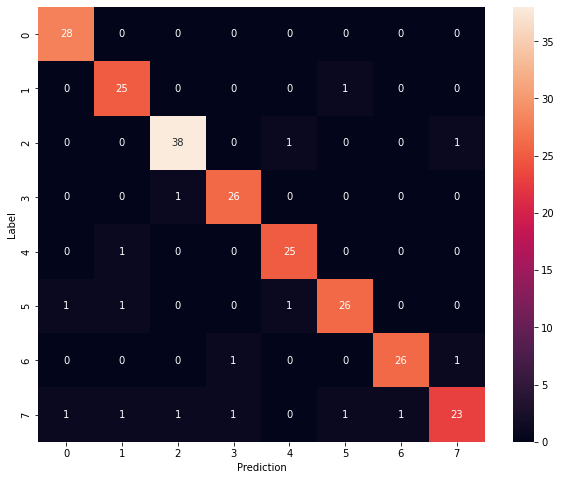

In [11]:
y_pred = np.argmax(model.predict(X_test), axis=1)

all_labels = list(range(8))

confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=all_labels, yticklabels=all_labels, annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [12]:
model.save("v13_params2.h5")

In [13]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 15
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = len(X_train)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

model_for_pruning.summary()

/Users/jasminewu/Documents/6115/II/Spoken_Digits/scripts/venv/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshape  (None, 128, 22, 1)       1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_conv2d   (None, 125, 19, 32)      1058      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropout  (None, 125, 19, 32)      1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_average  (None, 62, 9, 32)        1         
 _pooling2d (PruneLowMagnitu                                     
 de)                                                             
                                                        

/Users/jasminewu/Documents/6115/II/Spoken_Digits/scripts/venv/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/Users/jasminewu/Documents/6115/II/Spoken_Digits/scripts/venv/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)


In [14]:
import tempfile

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/15
13/13 [==============================] - 5s 167ms/step - loss: 0.0743 - accuracy: 0.9778 - val_loss: 0.0410 - val_accuracy: 0.9892
Epoch 2/15
13/13 [==============================] - 2s 152ms/step - loss: 0.0717 - accuracy: 0.9753 - val_loss: 0.0599 - val_accuracy: 0.9838
Epoch 3/15
13/13 [==============================] - 2s 148ms/step - loss: 0.0850 - accuracy: 0.9747 - val_loss: 0.0341 - val_accuracy: 0.9892
Epoch 4/15
13/13 [==============================] - 2s 149ms/step - loss: 0.0574 - accuracy: 0.9832 - val_loss: 0.0515 - val_accuracy: 0.9946
Epoch 5/15
13/13 [==============================] - 2s 151ms/step - loss: 0.0674 - accuracy: 0.9820 - val_loss: 0.0393 - val_accuracy: 0.9838
Epoch 6/15
13/13 [==============================] - 2s 151ms/step - loss: 0.0572 - accuracy: 0.9820 - val_loss: 0.0323 - val_accuracy: 0.9946
Epoch 7/15
13/13 [==============================] - 2s 153ms/step - loss: 0.0654 - accuracy: 0.9765 - val_loss: 0.0426 - val_accuracy: 1.0000
Epoch 

In [15]:
model_for_pruning.evaluate(X_test, y_test)

8/8 [==============================] - 0s 8ms/step - loss: 0.2653 - accuracy: 0.9142


[0.2652705907821655, 0.9141631126403809]

In [16]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /var/folders/vs/b_y62_cj4859tj4h1ch0glg80000gn/T/tmpqiuq62o8.h5
